# TP 1 : Nonnegative Matrix Factorization



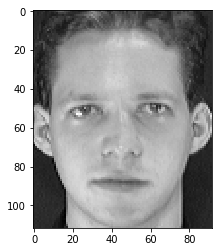

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.optimize
import time


# database is the directory containing the database of faces
# you will have to change it to make the code work on your session.

database = "C:/Users/Cally/Downloads/database"




# The build_matrix_from_faces function constructs the matrix M

def build_matrix_from_faces(folder=database, minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)





def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))




def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H




#To see the first face:
M = build_matrix_from_faces()
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()





# Small data to test the algorithm
M = build_matrix_from_faces(folder=database, minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
n, p = M.shape
k = 2




# Full data
#M = build_matrix_from_faces(folder=database, minidata=False)
#def unvectorize(W_H): return unvectorize_M(W_H, M)
#n, p = M.shape
#k = 38

## 1 Database

### Question 1.1

> Download and extract the database of faces, collected by AT&T Laboratories Cambridge, on https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html. How many images are there in the database? How many pixels are there in each image?

______________________________________________________________________________________________

<b>Answer: </b> 
  
There are 40 x 10 = 400 images in the database, and 92 x 112 = 10304 pixels in each of them.
______________________________________________________________________________________________

## 2 Presentation of the model

### Question 2.1

> Show that the objective function is not convex. Calculate its gradient. Is the gradient Lipschitz continuous?

______________________________________________________________________________________________

#### Answer: 
  
* <b>The objective function is not convex :</b>  
<br/>
<br/>
Indeed


* <b>The gradient is :</b>  
<br/>
<br/>

$\frac{\partial f}{\partial W} = \frac{1}{np}(WH-M)H^T$ and  

$\frac{\partial f}{\partial H} = \frac{1}{np}W^T(WH-M)$    

So the gradient is $\frac{1}{np}\left[\begin{array}{cc} (WH-M)H^T \\W^T(WH-M)  \end{array}\right]$


* <b>Is it Lipschitz continuous? :</b>  
<br/>
<br/>

______________________________________________________________________________________________

## 3 Find W when H0 is fixed

### Question 3.1

> We initialize the optimization algorithm as follows:  

In [24]:
W0, S, H0 = scipy.sparse.linalg.svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))  
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)

> What is the advantage of this choice? What would be other possibilities for the initialization?

______________________________________________________________________________________________

<b>Answer: </b> 
  
That initialization takes the general solution of the minimization problem (in particular in the case k = 1) and projects it onto the domain of definition of our constraints; it has the advantage of probably giving us first iterations close to the global solutions.
We could also initialize it randomly ( but still in the domain of the function ), or with zero matrices.
______________________________________________________________________________________________

<blockquote> In a first part, we would like to solve the simpler problem:
    
$g(W) = \dfrac{1}{2np}\left\|M-WH_{0}\right\|^2_F$   
$W^1 \in \underset{W≥0}{\arg\max}~~g(W)$ </blockquote>


### Question 3.2

<blockquote>Is the objective function g convex? Calculate its gradient. We will admit that the gradient
of $g$ is Lipschitz continuous with constant $L_{0} = \left\|(H^{0})^{T}H^{0}\right\|_{F}$</blockquote>

_________________________________________________________________________________________

<b>Answer:</b>

We already know from previous questions that :
$$
\nabla_W g(W) = \frac{1}{np} \left( WH_0 - M \right)\cdot H_0^T
$$
Then, it gives us the following Hessian matrix : 
$$
\nabla^2_W g(W)= \frac{1}{np} H_0^T\cdot H_0
$$

Since $H_0$ is a positive matrix, the Hessian matrix is positive, and so $g$ is convex.

__________________________________________________________________

### Question 3.3

<blockquote>Write a function to compute $g(W)$ and another to compute $∇g(W)$.
You can check your computations using the function scipy.optimize.check grad (as
check grad cannot deal with matrix variable, you may need to vectorize your variables).</blockquote>

In [25]:
def g(W):
    return ((( np.linalg.norm( M + (-1) * np.dot(W,H0), ord='fro' ) )**2 ) / (2*n*p) )

def grad_g(W):
    return ( np.dot((np.dot(W,H0) + (-1) * M),( np.transpose(H0) ) ) / ( n * p ) )




def val_g(W_l):
    W = W_l.reshape((n,k))
    return g(W)

def val_grad_g(W_l):
    W = W_l.reshape((n,k))
    return grad_g(W).ravel()
    

scipy.optimize.check_grad(val_g, val_grad_g, W0.ravel())

0.00011011222732815545

### Question 3.4

<blockquote>Let us define the function:

$ι_{\mathbb{R} _{+}} : \mathbb{R}  → \mathbb{R}  ∪ \left\{ +∞ \right\} $  
  
$ x \mapsto \begin{cases}
0 &\text{ if }x ≥ 0 \\
+∞ &\text{ si }x < 0
\end{cases}$  

Show that for all $γ > 0$, $prox_{γι_{\mathbb{R} _{+}}}$ is the projection onto $\mathbb{R} _{+}$.
</blockquote> 

______________________________________________________________________________________________

<b>Answer: </b> +
  
By definition, $prox_{γι_{\mathbb{R} _{+}}}(x) = \underset{y \in \mathbb{R}}{\arg\min}~~ \lbrack~~γι_{\mathbb{R} _{+}}(y)~+~\dfrac{1}{2}\left\|y-x\right\|^2~~\rbrack$

But, since $γι_{\mathbb{R} _{+}}(y)~=~+∞$ if $y < 0$ (since $γ > 0$), we can easily deduce that no minimum can be found if $y \in \mathbb{R} _{-}^{*}$. Thus:

$prox_{γι_{\mathbb{R} _{+}}}(x) = \underset{y \in \mathbb{R}_{+}}{\arg\min}~~ \lbrack~~γι_{\mathbb{R} _{+}}(y)~+~\dfrac{1}{2}\left\|y-x\right\|^2~~\rbrack~=~\underset{y \in \mathbb{R}_{+}}{\arg\min}~~ \lbrack~~\dfrac{1}{2}\left\|y-x\right\|^2~~\rbrack~~~~~$  since $γι_{\mathbb{R} _{+}}(y)~=~0$ for y ≥ 0


Then, it becomes quite clear that:
$prox_{γι_{\mathbb{R} _{+}}}(x) \mapsto \begin{cases}
0 &\text{ if }x < 0 \\
x &\text{ si }x ≥ 0
\end{cases}$  

$prox_{γι_{\mathbb{R} _{+}}}$ is indeed the projection onto $\mathbb{R} _{+}$.
______________________________________________________________________________________________

### Question 3.5

<blockquote>Code a function projected_gradient_method(val_g, grad_g, W0, gamma, N) that minimizes a function $g$ subject to nonnegativity constraints by the projected gradient method with a constant step size γ, starting from $W_{0}$ and stopping after N iterations.</blockquote>

______________________________________________________________________________________________

<b>Answer: </b> 

We seek to minimize $g$ for W ≥ 0, ie to minimize $g + ι_{\mathbb{R} _{+}}$ where $ι_{\mathbb{R} _{+}}$ would be applied on all matrix coefficients.  
Thus we can use the proximal gradient method, which uses the formula $x_{k+1}~=~prox_{γ_{k}g}(x_{k}~-~γ_{k}∇f(x_k))$ to minimize $f~+~g$ where $f$ has a L-Lipschitz gradient (it is the case here) and $γ_{k}$ is the step size; the results are better when using $γ_{k}~=~\dfrac{1}{L}$.  
Hence, we just have to use the projection onto $\mathbb{R}_{+}^{n*k}$ (since we often vectorize our matrix) just as follows:

______________________________________________________________________________________________

In [26]:
def projected_gradient_method(val_g, grad_g, W0, gamma, N):
    W = W0
    for i in range(N):
        W = np.maximum(0, W - gamma * grad_g(W).reshape((n,k)))
    return (W, val_g(W))

L0 = np.linalg.norm( np.dot(H0.transpose(),H0), ord='fro' ) / ( n * p )
gamma = 1 / L0

### Question 3.6

<blockquote>Use the function to minimize g with N = 100.</blockquote>

In [27]:
projected_gradient_method(g, grad_g, W0, gamma, 100)

(array([[ 0.        , 64.3604483 ],
        [ 0.        , 70.75177521],
        [ 0.        , 65.94946631],
        [39.75077154, 64.93387918],
        [24.66708428, 67.56358851],
        [ 0.        , 69.04538406],
        [ 0.        , 66.88002478],
        [19.14268487, 63.08968098],
        [58.43595376, 60.43372367],
        [ 8.51197175, 65.10600402]]), 442.2878543960471)

## 4 Algorithmic refinement for the problem with H0 fixed

### Question 4.1

<blockquote>Implement a line search to the projected gradient method, in order to free ourselves from
the need of a known Lipschitz constant.</blockquote>

______________________________________________________________________________________________

<b>Answer: </b> 

We implement a Taylor-based line search: it is a gradient method, thus at each step: $x_{k+1}~=~x_{k}~-~γ_{k}∇f(x_k)$.  
The Taylor-based line search chooses a step size $γ_{k}$ such that for the tentative update defined by $x^{+}(γ_k)~=~x_k~−~γ_{k}∇f(x_k)$, we have :  
$ f(x^{+}(γ_k))~≤~f(x_k)~+~<∇f(xk),~x^{+}(γ_k)~−~x_{k}>~+~\dfrac{1}{2γ_k}\left\|x_k~−~x^{+}(γ_k)\right\|^2$

We set b > 0, a ∈ (0, 1) and at each step we find the first nonnegative integer l such that if we set $γ_k~=~ba^l$ the inequality is verified.  

Classical choices for the parameters are $a = 0.5$ and $b = 2γ_{k−1}$; we'll choose that here (and $γ_{0}=1$).



______________________________________________________________________________________________

In [28]:
#To simplify the code, we define the following function:

def dot_product_frobenius(A,B):
    return np.trace(np.dot(A,np.transpose(B)))



def line_search_method(val_g, grad_g, W0, N):
    W=W0
    gamma=0.5
    a=0.5
    for i in range(N):
        b = 2 * gamma
        l = 0
        W_plus = np.maximum(W - b * (a**l) * grad_g(W).reshape((n,k)),0)
        while( 
            val_g( W_plus ) > ( val_g(W) + dot_product_frobenius( grad_g(W).reshape((n,k)), W_plus - W )
                                  + ( np.linalg.norm( W - W_plus )**2 )/( b * (a**l) ) ) 
        ):
            l+=1
            W_plus = np.maximum(W - b * (a**l) * grad_g(W).reshape((n,k)),0)
        gamma = b * (a**l)
        W = np.maximum(W - gamma * grad_g(W).reshape((n,k)),0)
    return (W, val_g(W))
    
    


(array([[ 0.        , 64.3604483 ],
        [ 0.        , 70.75177521],
        [ 0.        , 65.94946631],
        [41.69483347, 64.70697438],
        [25.80283743, 67.43145254],
        [ 0.        , 69.04538406],
        [ 0.        , 66.88002478],
        [18.85454089, 63.13069023],
        [60.93474248, 60.14423685],
        [ 8.25851268, 65.13962292]]), 442.21842244895686)

### Question 4.2

<blockquote>Compare the performance of both algorithms.</blockquote>

In [29]:
# Computing the time that the first algorithm takes for 100 iterations:

begin_proj = time.time()
projected_gradient_method(g, grad_g, W0, gamma, 100)
end_proj = time.time()




# Computing the time that the line search algorithm takes for 100 iterations:

begin_line = time.time()
line_search_method(g,grad_g,W0,100)
end_line = time.time()


# Comparing:

print("The simple projected gradient method takes {} seconds for 100 iterations".format(end_proj-begin_proj))
print("The line search projected gradient method takes {} seconds for 100 iterations".format(end_line-begin_line))

The simple projected gradient method takes 0.4855821132659912 seconds for 100 iterations
The line search projected gradient method takes 3.8914384841918945 seconds for 100 iterations


__________________________________________________________________________________________________________

<b>Answer:</b>

As we can see, the projected gradient method is way faster than the line search integrated one; it is quite logical. Indeed, in each step, in the latter case, we search for a good step size for the descent, using a loop inside another loop; in the former case, the step size is fixed, sparing us lots of operations. But at the same time, it makes the line search algorithm more precise: at each step, the step size is tailored to the neighborhood of g(W), and it gives better results than using one constant fixed step size, even if we choose the inverse of the Lipschitz continuous value to make it as precise as possible. Once again, it is quite logical to note that adaptative methods give more precise results, in return of worse time complexity.

_________________________________________________________________________________________________________

## 5 Resolution of the full problem

### Question 5.1

Solve Problem (1) by the projected gradient method with line search for N = 1000 iterations.
What does the algorithm return?

In [39]:
#First, we implement the overall function & the two gradients:

def f(W, H):
    return np.linalg.norm( M - np.dot(W, H) ) ** 2 / (2 * n * p)

def grad_W(W, H):
    return np.dot(np.dot(W, H) - M, H.transpose()) / (n * p)

def grad_H(W, H):
    return np.dot(W.transpose(), np.dot(W, H) - M) / (n * p)


#Then, I implemented the Armijo line search (for beta=0.5, it is equivalent to the Taylor-based one):


def projected_line_search_gradient_method(f,W0,H0,gradW,gradH,N,a=0.5,b=0.5,beta=0.5):

    W_plus = W0
    H_plus = H0
    for i in range(N):
        W = W_plus
        H = H_plus
        l = 0
        W_plus = np.maximum(0, W - b * (a ** l) * gradW(W, H))
        H_plus = np.maximum(0, H - b * (a ** l) * gradH(W, H))
        
        #the loop condition is modified
        while (f(W_plus,H_plus) > f(W,H) + beta * np.vdot( gradW( W, H),W_plus - W) 
               + beta * np.vdot(gradH( W, H),H_plus - H)):
            l += 1
            W_plus = np.maximum(0, W - b * (a**l) * gradW(W, H))
            H_plus = np.maximum(0, H - b * (a**l) * gradH(W, H))
    return f(W_plus, H_plus),W_plus,H_plus



projected_line_search_gradient_method(f,W0,H0,grad_W,grad_H,100,a=0.5,b=0.5,beta=0.5)

(408.2250021381322, array([[ 0.        , 66.29054872],
        [ 0.        , 72.61767933],
        [ 0.        , 67.9283982 ],
        [34.90836853, 63.33791994],
        [24.63112676, 66.58721166],
        [ 2.43420989, 70.27052717],
        [ 0.67070973, 68.44791169],
        [26.70328914, 60.85239692],
        [51.30269622, 57.18946527],
        [14.18826782, 64.52667722]]), array([[1.52617818e-01, 4.67778083e-02, 6.15715363e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.93159094e-01, 7.46829871e-01, 7.19503483e-01, ...,
         7.63586594e-01, 7.19394518e-01, 7.53516778e-01]]))

### Question 5.2

<blockquote> </blockquote>

__________________________________________________________________________________________________________

<b>Answer:</b>
Let $f(W,H)=\frac{1}{2np}||\left(M-WH)\right ||^{2}_F$,  
for $t\geq1$, we know that :   
$W_t=argmin_W \frac{1}{2np}||\left(M-WH)\right ||^{2}_F$ and   
$H_t=argmin_H \frac{1}{2np}||\left(M-WH)\right ||^{2}_F$   
  
so, $f(W_t,H_{t-1})<f(W_{t-1},H_{t-1})$ and $f(W_t,H_t)<f(W_t,H_{t-1})$   
thus we have, $f(W_t,H_t)<f(W_{t-1},H_{t-1})$ i.e the sequence is decreasing  
  
Moreover, the sequence is minored by 0 since the norm is always positive so the whole sequence is converging
__________________________________________________________________________________________________________


### Question 5.3

<blockquote>Code the alternate minimizations method.</blockquote>